# Выпускной проект: Телеком - определение неэффективных операторов

**"Нупозвони"** - провайдер виртуальной телефонии. Его клиенты - колл-центры, которые:
- распределяют входящие вызовы на операторов;
- совершают исходящие вызовы силами операторов.
Также операторы могут делать внутренние вызовы - вызовы между друг другом внутри сети виртуальной телефонии.

**Задача:** Проанализировать критерии эффективности операторов. Выработать алгоритм выявления неэффективных операторов.

Признаки низкой эффективности:
- много пропущенных входящих звонков;
- долгое время ожидания ответа при входящих внешних вызовах;
- мало исходящих вызовов - в случае тех колл-центров, что специализируются на обзвонах, а не на обработке входящих вызовов.

**Материалы(ссылка на презентацию):**[презентация](https://disk.yandex.ru/i/NQ6EEI_VCl2aEg)

## Загрузка и ознакомление с данными

In [1]:
#загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import scipy
from scipy import stats as st
import datetime

pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_format', '{:,.3f}'.format)

In [2]:
#загружаем данные
try:
    tarifs = pd.read_csv('telecom_clients.csv')
    data = pd.read_csv('telecom_dataset.csv')
except:
    tarifs = pd.read_csv('/datasets/telecom_clients.csv')
    data = pd.read_csv('/datasets/telecom_dataset.csv')

In [3]:
# создаем функцию для знакомства с данными
def info(data):
    print('\033[1m' + 'Общая информация о датасете:' + '\033[0m')
    data.info()
    print('*'*50)
    print('\033[1m' + 'Статистические характеристики:' + '\033[0m')
    display(data.describe(include='all'))
    print('*'*50)
    print('\033[1m' + 'Данные в датасете:' + '\033[0m')
    display(data)
    print('*'*50)
    display('Количество дубликатов:', data.duplicated().sum())
    display('Количество пропусков:', pd.concat([data.isna().sum(), data.isna().mean()], axis=1)\
    .rename(columns={0:'кол-во', 1:'доля'})\
    .style.format({'кол-во':'{:.0f}', 'доля':'{:.2%}'}))

Познакомимся с таблицей `tarifs`

In [4]:
info(tarifs)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
**************************************************
Статистические характеристики:


,user_id,tariff_plan,date_start
count,732.000,732,732
unique,NaN,3,73
top,NaN,C,2019-09-24
freq,NaN,395,24
mean,"167,431.928",NaN,NaN
std,633.810,NaN,NaN
min,"166,373.000",NaN,NaN
25%,"166,900.750",NaN,NaN
50%,"167,432.000",NaN,NaN
75%,"167,973.000",NaN,NaN


**************************************************
Данные в датасете:


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


**************************************************


'Количество дубликатов:'

0

'Количество пропусков:'

,кол-во,доля
user_id,0,0.00%
tariff_plan,0,0.00%
date_start,0,0.00%


Колонки в `tarifs`:
- `user_id` - идентификатор клиентского аккаунта в сервисе
- `tariff_plan` - текущий тарифный план клиента
- `date_start` - дата регистрации клиента в сервисе

В таблице 732 строки. Дубликатов нет. Пропусков в данных нет. Тип данных в колонке `date_start` необходимо изменить на дату. Всего у юзеров 3 тарифных плана: А, В, С.

Познакомимся с таблицей `data`

In [5]:
info(data)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
**************************************************
Статистические характеристики:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
count,"53,902.000",53902,53902,53785,"45,730.000",53902,"53,902.000","53,902.000","53,902.000"
unique,NaN,119,2,2,NaN,2,NaN,NaN,NaN
top,NaN,2019-11-25 00:00:00+03:00,out,False,NaN,False,NaN,NaN,NaN
freq,NaN,1220,31917,47621,NaN,30334,NaN,NaN,NaN
mean,"167,295.344",NaN,NaN,NaN,"916,535.993",NaN,16.451,866.684,"1,157.133"
std,598.884,NaN,NaN,NaN,"21,254.123",NaN,62.917,"3,731.791","4,403.469"
min,"166,377.000",NaN,NaN,NaN,"879,896.000",NaN,1.000,0.000,0.000
25%,"166,782.000",NaN,NaN,NaN,"900,788.000",NaN,1.000,0.000,47.000
50%,"167,162.000",NaN,NaN,NaN,"913,938.000",NaN,4.000,38.000,210.000
75%,"167,819.000",NaN,NaN,NaN,"937,708.000",NaN,12.000,572.000,902.000


**************************************************
Данные в датасете:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,"880,022.000",True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.000",True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.000",False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,"880,022.000",True,3,0,25
...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,"957,922.000",True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,"957,922.000",False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,"957,922.000",False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,"957,922.000",False,4,3130,3190


**************************************************


'Количество дубликатов:'

4900

'Количество пропусков:'

,кол-во,доля
user_id,0,0.00%
date,0,0.00%
direction,0,0.00%
internal,117,0.22%
operator_id,8172,15.16%
is_missed_call,0,0.00%
calls_count,0,0.00%
call_duration,0,0.00%
total_call_duration,0,0.00%


Колонки в датафрейме `data`:
- `user_id` - идентификатор клиентского аккаунта в сервисе
- `date` - дата статистики
- `direction` - направление вызовов(out-исходящий, in-входящий вызов)
- `internal` - является ли звонок внутренним звонком между операторами клиента
- `operator_id` - идентификатор оператора
- `is_missed_call` - является ли звонок пропущенным
- `calls_count` - количество звонков
- `call_duration` - длительность звонка(без учета времени ожидания)
- `total_call_duration` - длительность звонка(с учетом времени ожидания)

В таблице **9** колонок и **53902**строки. В данных присутствуют дубликаты в количестве **4900**штук(**9%** от всего датасета) . Также есть пропущенные значения:
- в `internal` **117**значений(**0,22%** от общего объема данных)
- в `operator_id` **8172**значений(**15,16%**)

Предлагаю избавится от дубликатов, т.к.в датасете представлены агрегированные данные по дням, пользователям и операторам и одинаковых строк быть не должно. Также предлагаю избавиться от строк с пропущенным значением в колонке `internal`, т.к.не представляется возможным без дополнительных данных определить чем их можно заполнить. Что касается данных с пропущенным `operator_id` предлагаю вынести их в отдельный датафрейм и поисследовать отдельно от основных данных, потому что нам нужно выявить неэффективных операторов, а без идентификатора это сделать невозможно. Но удалять их полностью не стоит, потому что это довольно большой объем информации и он может содержать какие-то инсайты.

Данные в столбце `date` необходимо привести типу данных даты, а в столбце `operator_id` к целочисленному значению.

## Предобработка данных

### Удаляем дубликаты

В таблице `tarifs` нет дубликатов, поэтому удаляем их только из таблицы `data`

In [6]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

### Убираем звонки с пропущенным `internal`

Для начала убедимся что в данных с пропущенным значением в `internal`нет никаких закономерностей.

In [7]:
data_internal_nan = data[data['internal'].isna() == True]
display(data_internal_nan.sample(20))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
39878,168018,2019-11-28 00:00:00+03:00,in,NaN,NaN,True,1,0,2
46717,168291,2019-11-28 00:00:00+03:00,out,NaN,NaN,True,3,0,93
15060,166916,2019-10-23 00:00:00+03:00,in,NaN,"906,400.000",False,1,81,110
34701,167650,2019-10-24 00:00:00+03:00,in,NaN,NaN,True,2,0,106
39515,167998,2019-10-23 00:00:00+03:00,in,NaN,NaN,True,1,0,2
16957,166983,2019-09-02 00:00:00+03:00,in,NaN,"901,880.000",False,1,119,127
21081,167078,2019-11-13 00:00:00+03:00,in,NaN,"935,348.000",False,2,73,84
41858,168091,2019-11-13 00:00:00+03:00,in,NaN,"958,460.000",True,1,85,136
47702,168361,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,6,0,14
13716,166884,2019-09-17 00:00:00+03:00,in,NaN,NaN,True,21,0,9


In [8]:
data_internal_nan.groupby('direction')['user_id'].agg('count')

direction
in     108
out      2
Name: user_id, dtype: int64

In [9]:
data_internal_nan.groupby('is_missed_call')['user_id'].agg('count')

is_missed_call
False    54
True     56
Name: user_id, dtype: int64

Большинство данных в срезе относятся к входящим. но есть и 2 исходящих, некоторые содержат `operator_id`, а некоторые нет, присутствуют как пропущенные так и не пропущенные звонки. Вобщем сделать однозначных выводов по поводу природы возникновения пропусков в столбце `internal` невозможно, поэтому кажется решение избавится от этих строк является оправданным.

In [10]:
#удаляем строки
data.dropna(subset = ['internal'], inplace = True)
display('Количество пропусков:', pd.concat([data.isna().sum(), data.isna().mean()], axis=1)\
    .rename(columns={0:'кол-во', 1:'доля'})\
    .style.format({'кол-во':'{:.0f}', 'доля':'{:.2%}'}))

'Количество пропусков:'

,кол-во,доля
user_id,0,0.00%
date,0,0.00%
direction,0,0.00%
internal,0,0.00%
operator_id,7401,15.14%
is_missed_call,0,0.00%
calls_count,0,0.00%
call_duration,0,0.00%
total_call_duration,0,0.00%


Остались пропуска только в столбце `operator_id`, вынесем их в отдельный датафрейм.

### Убираем строки с пропущенным `operator_id` в отдельный датафрейм

Разделим датасеты с пропущенным и заполненным значением в `operator_id`.

In [11]:
data_clear = data.dropna()
print('\033[1m' + 'Информация об очищенном датасете:' + '\033[0m')
display(data_clear.info())
data_operator_nan = data[data['operator_id'].isna() == True]
print('\033[1m' + 'Информация о датасете с пропущенным идентификатором оператора:' + '\033[0m')
display(data_operator_nan.info())

Информация об очищенном датасете:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 49000
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              41491 non-null  int64  
 1   date                 41491 non-null  object 
 2   direction            41491 non-null  object 
 3   internal             41491 non-null  object 
 4   operator_id          41491 non-null  float64
 5   is_missed_call       41491 non-null  bool   
 6   calls_count          41491 non-null  int64  
 7   call_duration        41491 non-null  int64  
 8   total_call_duration  41491 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 2.9+ MB


None

Информация о датасете с пропущенным идентификатором оператора:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7401 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              7401 non-null   int64  
 1   date                 7401 non-null   object 
 2   direction            7401 non-null   object 
 3   internal             7401 non-null   object 
 4   operator_id          0 non-null      float64
 5   is_missed_call       7401 non-null   bool   
 6   calls_count          7401 non-null   int64  
 7   call_duration        7401 non-null   int64  
 8   total_call_duration  7401 non-null   int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 527.6+ KB


None

В датасете без пропусков у нас **41491**строка(**77%** от первоночального размера), а в датасете с пропущенным значением `operator_id` **7401**строка.

### Меняем типы данных

Меняем тип данных в таблице `data_clear`, столбце `operator_id` с float на int

In [12]:
data_clear['operator_id'] = data_clear['operator_id'].astype('int64')

In [13]:
data_clear['internal'] = data_clear['internal'].astype('bool')

Поменяем тип данных в колонках с датами

In [14]:
#изменим типы данных в столбцах связанных со временем
tarifs['date_start'] = pd.to_datetime(tarifs['date_start'], format='%Y-%m-%d')
data_clear['date'] = pd.to_datetime(data_clear['date']).dt.tz_localize(None)
data_operator_nan['date'] = pd.to_datetime(data_operator_nan['date']).dt.tz_localize(None)

In [15]:
data_operator_nan.info()
data_operator_nan

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7401 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              7401 non-null   int64         
 1   date                 7401 non-null   datetime64[ns]
 2   direction            7401 non-null   object        
 3   internal             7401 non-null   object        
 4   operator_id          0 non-null      float64       
 5   is_missed_call       7401 non-null   bool          
 6   calls_count          7401 non-null   int64         
 7   call_duration        7401 non-null   int64         
 8   total_call_duration  7401 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 527.6+ KB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
8,166377,2019-08-06,in,False,NaN,True,4,0,62
16,166377,2019-08-07,in,False,NaN,True,2,0,24
26,166377,2019-08-12,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
48978,168601,2019-11-27,in,False,NaN,True,2,0,39
48982,168601,2019-11-28,in,False,NaN,True,1,0,19
48990,168603,2019-11-28,in,False,NaN,True,1,0,30
48994,168606,2019-11-08,in,False,NaN,True,6,0,121


### Рассчитываем дополнительные параметры(длительность времени ожидания, среднее время ожидания, день недели, на который приходится звонок)

In [16]:
#создаем колонку со временем ожидания ответа
data_clear['waiting_time'] = data_clear['total_call_duration'] - data_clear['call_duration']

In [17]:
#создаем колонку со средним временем ожидания на один звонок
data_clear['avg_wait_time'] = data_clear['waiting_time'] / data_clear['calls_count']

In [18]:
#извлечем из даты день недели
data_clear["day_of_week"] = data_clear["date"].dt.weekday
data_operator_nan["day_of_week"] = data_operator_nan["date"].dt.weekday

In [19]:
#извлечем из даты месяц
data_clear["month"] = data_clear["date"].dt.month
data_operator_nan["month"] = data_operator_nan["date"].dt.month

In [79]:
#добавим столбец с сумой звонков по операторам(он нужен для разделения операторов по специализации)
# общее количество
data_clear['sum_calls'] = np.nan
data_clear['sum_calls'] = data_clear["sum_calls"]\
                        .fillna(data_clear.groupby("operator_id")["calls_count"].transform("sum"))
# входящие
data_clear['in_calls'] = np.nan
data_clear['in_calls'] = data_clear["in_calls"]\
                        .fillna(data_clear.query('direction == "in"')
                        .groupby("operator_id")["calls_count"].transform("sum"))

# исходящие
data_clear['out_calls'] = np.nan
data_clear['out_calls'] = data_clear["out_calls"]\
                        .fillna(data_clear.query('direction == "out"')
                        .groupby("operator_id")["calls_count"].transform("sum"))

data_clear.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time,day_of_week,month,sum_calls,in_calls,out_calls
31470,167497,2019-11-22,out,False,924960,True,1,0,39,39,39.000,4,11,284.000,NaN,230.000
31114,167497,2019-11-11,out,True,924960,False,7,547,633,86,12.286,0,11,284.000,NaN,230.000
25843,167180,2019-10-25,out,False,905932,False,8,1220,1280,60,7.500,4,10,370.000,NaN,334.000
42772,168154,2019-11-27,in,False,939376,False,9,1039,1127,88,9.778,2,11,"1,336.000",261.000,NaN
32552,167543,2019-11-20,out,False,928382,True,1,0,25,25,25.000,2,11,18.000,NaN,9.000


## Исследовательский анализ данных (EDA)

Узнаем за какой период мы имеем данные.

In [21]:
print('Дата начала периода:', data_clear['date'].min())
print('Дата окончания периода:', data_clear['date'].max())

Дата начала периода: 2019-08-02 00:00:00
Дата окончания периода: 2019-11-28 00:00:00


Посмотрим сколько у нас уникальных операторов и пользователей

In [22]:
print('Количество уникальных пользователей:', data_clear['user_id'].nunique())

Количество уникальных пользователей: 290


In [23]:
print('Количество уникальных операторов:', data_clear['operator_id'].nunique())

Количество уникальных операторов: 1092


### Делим датасеты по признаку входящих и исходящих звонков, а также операторов специализирующихся на входящих и исходящих.

Посмотрим на распределение операторов у пользователей.

In [24]:
round(data_clear.groupby('user_id')['operator_id'].nunique().describe(), 2)

count   290.000
mean      3.770
std       5.720
min       1.000
25%       1.000
50%       2.000
75%       4.000
max      50.000
Name: operator_id, dtype: float64

В среднем на пользователя приходится по **3-4** оператора, но если смотреть на медиану то получим значение в **2** оператора. Перекос идет из-за выбросов, это свидетельствует о наличии колл-центров с большим количеством операторов.

Посмотрим соотношение входящих и исходящих звонков в датасете

In [25]:
data_clear['direction'].value_counts()

out    28813
in     12678
Name: direction, dtype: int64

Имеем **28813** строк со входящими звонками и **12678**строк с исходящими.

Теперь посмотрим может ли оператор работать со входящими и исходящими звонками одновременно

In [26]:
operator_in_out = data_clear.groupby('operator_id').agg({'direction':'nunique'})
operator_in_out_all = operator_in_out[operator_in_out['direction'] == 2].reset_index()
operator_in_out_all['operator_id'].nunique()

544

Половина операторов работает как с входящими, так и с исходящими звонками, что усложняет нам задачу разграничения. Для разделения операторов за норму примем 75%, т.е.если больше 75% звонков оператор совершает исходящих, то будем считать что он специализируется на исходящих, так же и с входящими.

In [27]:
# входящие звонки
incoming_calls = data_clear[data_clear['direction'] == "in"].reset_index()
# исходящие звонки
out_calls = data_clear[data_clear['direction'] == "out"].reset_index()

In [28]:
# отбираем операторов, специализирующихся на входящих
incoming_calls['percent_in'] = (incoming_calls['in_calls'] / incoming_calls['sum_calls']) * 100
incoming_operators = incoming_calls.query('percent_in > 75')
print('Количество операторов, специализирующихся на входящих:', incoming_operators['operator_id'].nunique())

Количество операторов, специализирующихся на входящих: 272


In [30]:
out_calls['percent_out'] = (out_calls['out_calls'] / out_calls['sum_calls']) * 100
out_operators = out_calls.query('percent_out > 75')
print('Количество операторов, специализирующихся на исходящих:', out_operators['operator_id'].nunique())

Количество операторов, специализирующихся на исходящих: 599


После разграничесния на операторов, специализирующихся на входящих и исходящих осталось 221 оператор не попавший ни в одну категорию. Будем считать что они совершают как входящие, так и исходящии на протяжении рабочего дня.

### Строим гистограммы и диаграммы размаха для числовых показателей. Разбираемся с выбросами.

In [31]:
#определяем рассматриваемые параметры
parametrs = {'calls_count':'Количество звонков', 'call_duration':'Длительность разговора (без времени ожидания)', 'waiting_time':'Время ожидания', 'avg_wait_time': 'Среднее время ожидания одного звонка' } 

Колонку `total_call_duration` решено не брать, т.к `waiting_time` и `avg_wait_time` являются производными от нее и выбросы посмотрим по ним.

In [32]:
#создаем функцию для отображения характеристик и отрисовки графиков
def analis(data, list_col):
    for parametr, name in parametrs.items():
        print('\nКолонка:', parametr,
              '\nОсновные характеристики:\n', data[parametr].describe())
        data[parametr].hist(bins='fd', figsize=(16,5))
        plt.title('Распределение параметров', fontsize=12)
        plt.xlabel(name, fontsize=11)
        plt.ylabel('Количество', fontsize=12)
        plt.show()
        data.boxplot(parametr).set(title='Распределение параметров', ylabel=name)
        plt.show()

#### Исследование входящих непропущенных внешних вызовов

In [33]:
incoming_not_missed_calls = incoming_calls.query('is_missed_call == False and internal == False')
incoming_not_missed_calls

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time,day_of_week,month,sum_calls,in_calls,out_calls,percent_in
0,25,166377,2019-08-12,in,False,880028,False,1,407,411,4,4.000,0,8,"2,560.000",63.000,NaN,2.461
1,32,166377,2019-08-13,in,False,880028,False,1,88,102,14,14.000,1,8,"2,560.000",63.000,NaN,2.461
2,35,166377,2019-08-14,in,False,880026,False,2,197,218,21,10.500,2,8,"2,232.000",24.000,NaN,1.075
3,37,166377,2019-08-14,in,False,880028,False,1,33,37,4,4.000,2,8,"2,560.000",63.000,NaN,2.461
4,45,166377,2019-08-15,in,False,880028,False,1,23,27,4,4.000,3,8,"2,560.000",63.000,NaN,2.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12672,48968,168601,2019-11-22,in,False,952914,False,2,429,442,13,6.500,4,11,658.000,78.000,NaN,11.854
12673,48973,168601,2019-11-25,in,False,952914,False,7,1229,1282,53,7.571,0,11,658.000,78.000,NaN,11.854
12674,48976,168601,2019-11-26,in,False,952914,False,4,539,562,23,5.750,1,11,658.000,78.000,NaN,11.854
12675,48979,168601,2019-11-27,in,False,952914,False,2,53,77,24,12.000,2,11,658.000,78.000,NaN,11.854



Колонка: calls_count 
Основные характеристики:
 count   11,629.000
mean         7.924
std         15.624
min          1.000
25%          1.000
50%          3.000
75%          8.000
max        273.000
Name: calls_count, dtype: float64


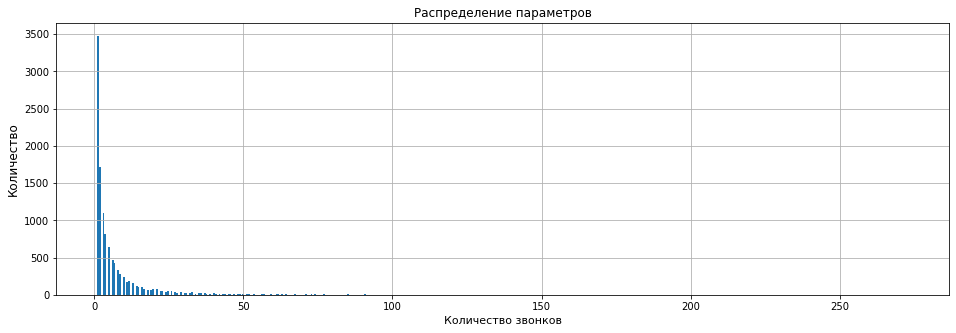

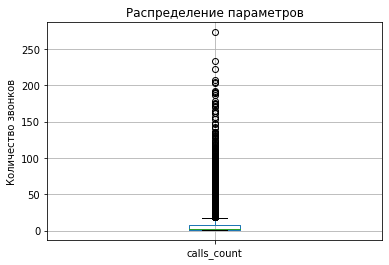


Колонка: call_duration 
Основные характеристики:
 count   11,629.000
mean       812.206
std      1,528.273
min          1.000
25%         87.000
50%        310.000
75%        921.000
max     33,897.000
Name: call_duration, dtype: float64


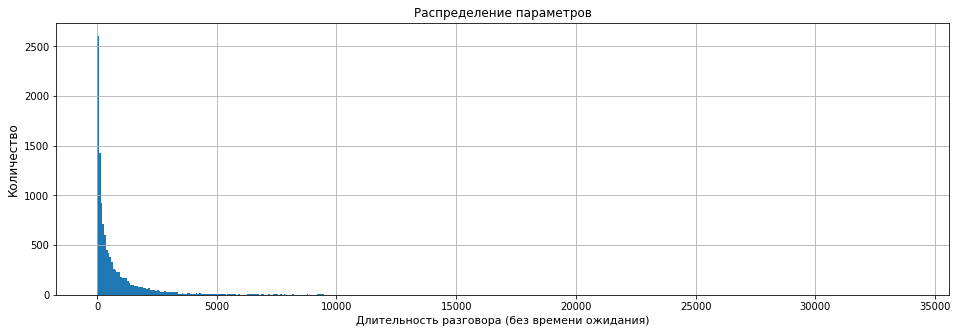

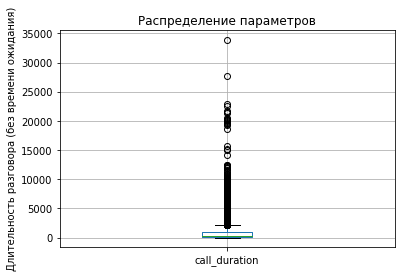


Колонка: waiting_time 
Основные характеристики:
 count   11,629.000
mean       103.750
std        192.174
min          0.000
25%         18.000
50%         42.000
75%        105.000
max      3,998.000
Name: waiting_time, dtype: float64


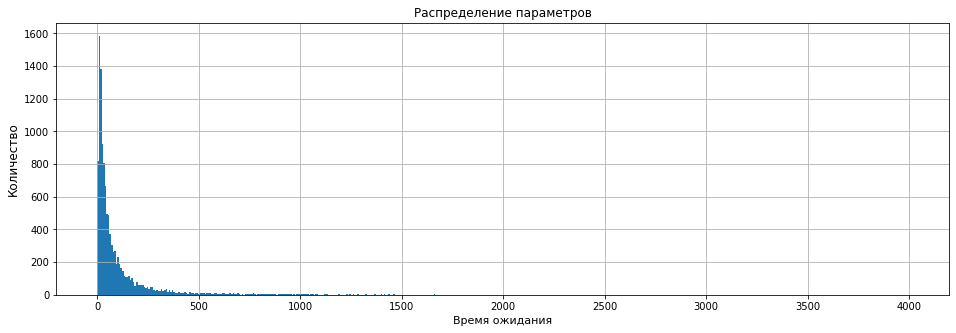

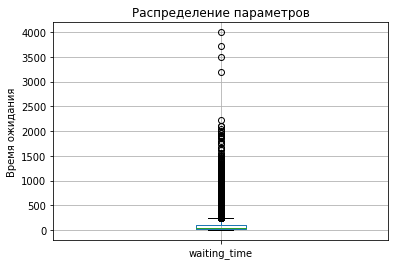


Колонка: avg_wait_time 
Основные характеристики:
 count   11,629.000
mean        16.374
std         13.169
min          0.000
25%          7.875
50%         13.000
75%         21.136
max        261.000
Name: avg_wait_time, dtype: float64


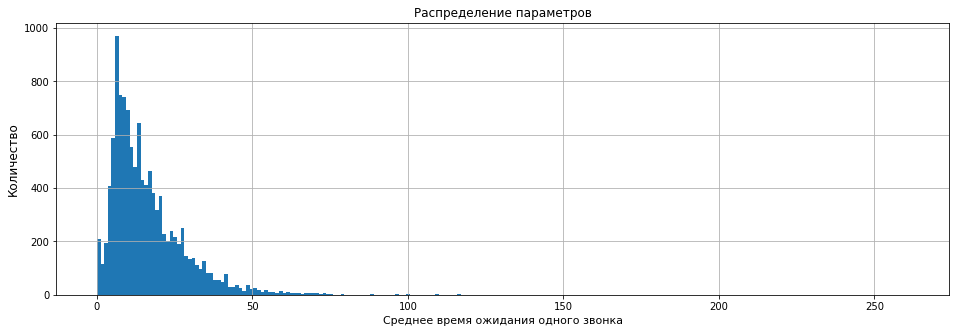

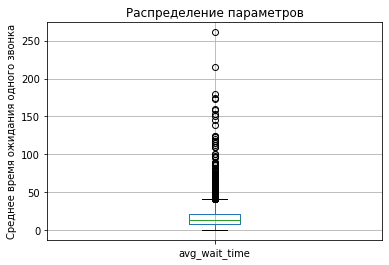

In [34]:
analis(incoming_not_missed_calls, parametrs)

Очень много выбросов из-за чего стандартное отклонение больше средних показателей, уберем данные по **90** перцентилю и снова посмотрим.

In [35]:
incoming_not_missed_calls = incoming_not_missed_calls[incoming_not_missed_calls['calls_count']\
                                                      <= incoming_not_missed_calls['calls_count'].quantile(0.90)]
incoming_not_missed_calls = incoming_not_missed_calls[incoming_not_missed_calls['call_duration']\
                                                      <= incoming_not_missed_calls['call_duration'].quantile(0.90)]
incoming_not_missed_calls = incoming_not_missed_calls[incoming_not_missed_calls['waiting_time']\
                                                      <= incoming_not_missed_calls['waiting_time'].quantile(0.90)]


Колонка: calls_count 
Основные характеристики:
 count   8,494.000
mean        2.870
std         2.557
min         1.000
25%         1.000
50%         2.000
75%         4.000
max        18.000
Name: calls_count, dtype: float64


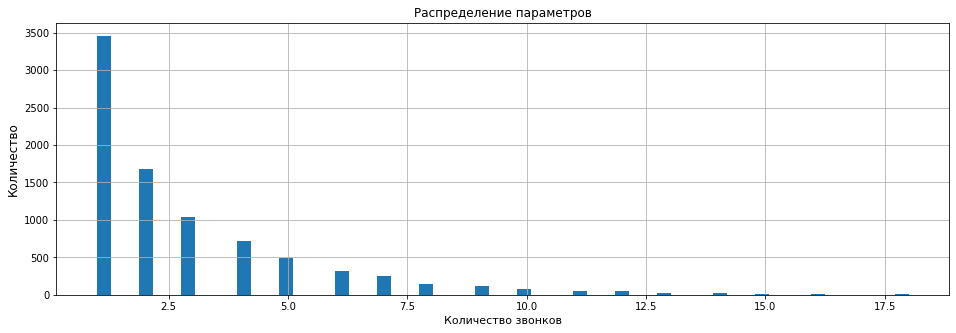

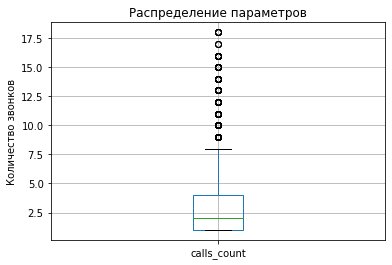


Колонка: call_duration 
Основные характеристики:
 count   8,494.000
mean      281.719
std       294.652
min         1.000
25%        57.000
50%       168.000
75%       417.000
max     1,268.000
Name: call_duration, dtype: float64


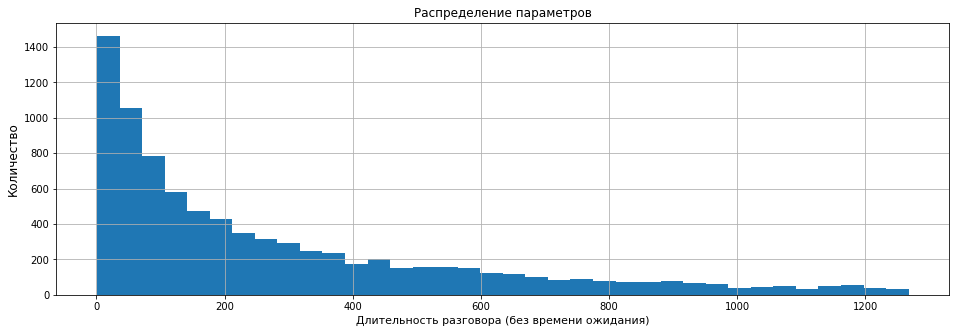

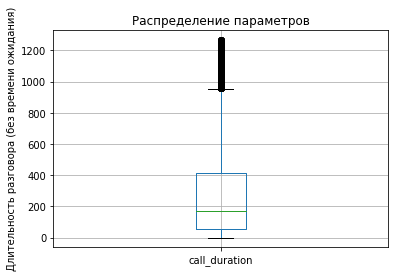


Колонка: waiting_time 
Основные характеристики:
 count   8,494.000
mean       36.809
std        29.445
min         0.000
25%        14.000
50%        27.000
75%        52.000
max       125.000
Name: waiting_time, dtype: float64


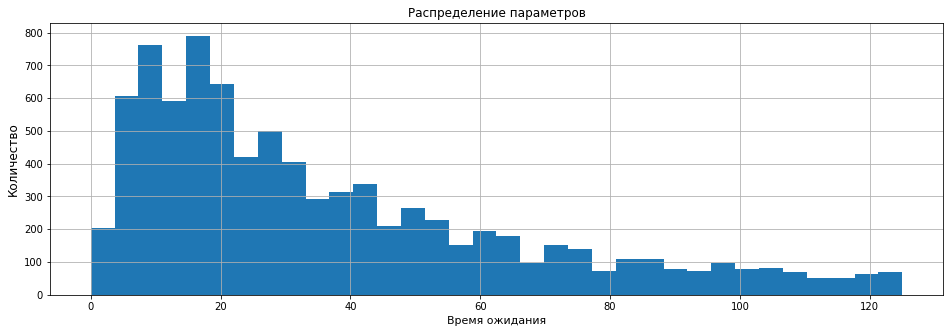

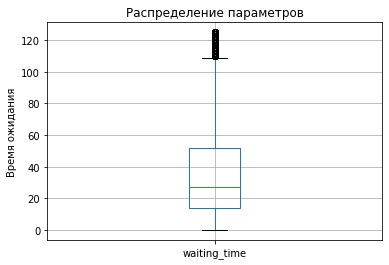


Колонка: avg_wait_time 
Основные характеристики:
 count   8,494.000
mean       15.595
std        11.688
min         0.000
25%         7.833
50%        13.000
75%        20.000
max       124.000
Name: avg_wait_time, dtype: float64


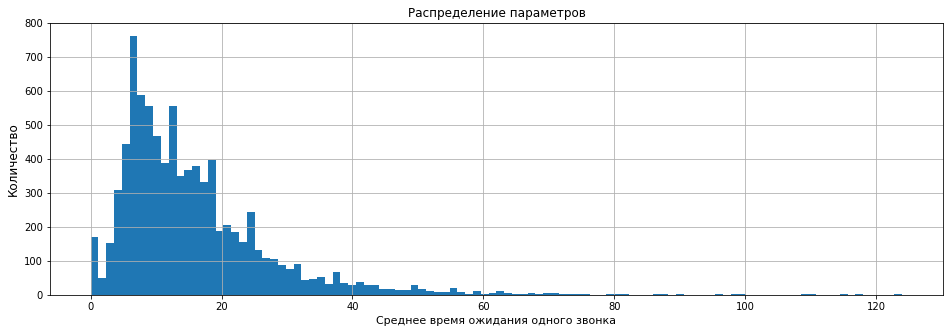

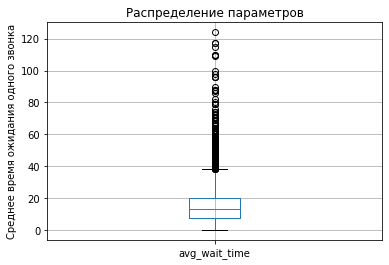

In [36]:
analis(incoming_not_missed_calls, parametrs)

По очищенным данным видим, что операторы принимают мало вхоядщих звонков(в среднем **2-3**), видимо остальное время занято исходящими звонками. Это может быть связано со пецификой работы колл-центров. Время ожидания больше **35** секунд явно плохо как и разговор более **300**секунд

[Внешние источники](https://www.mango-office.ru/products/contact-center/vozmozhnosti/kpi/) говорят о том что KPI в отрасли по времени ожидания сотавляет **15-20** секунд, после которого время ожидания будет считаться высоким. Зададим порог эффективности в **20**секунд.

Также из открытых источников, а именно [источник](https://wilstream.ru/stati/kpi-koll-tsentra/) можно найти еще один критерий эффектиности оператора AHT: average handling time — время обработки обращения
Метрика `аverage handling time(АНТ)` демонстрирует количество времени, которое в среднем необходимо специалисту для обслуживания запроса.
Индустриальный стандарт АНТ — от **4** до **6** минут(в нашем случае **240-360**секунд)
Если разговор длится дольше, возникают вопросы к уровню компетентности оператора — значит, он недостаточно хорошо разбирается в продукте и ему приходится искать ответы на вопросы клиента. Кроме того, если беседа превышает стандартное время, собирается очередь звонков и рушатся другие важные показатели.
Но так как мы не знаем о чем в действительности консультируют или информируют операторы остановимся на тех метриках, которые были определены нами заранее.

#### Исследование исходящих непропущенных вызовов

In [37]:
out_not_missed_calls = out_calls.query('internal == False')


Колонка: calls_count 
Основные характеристики:
 count   23,869.000
mean        24.943
std         77.046
min          1.000
25%          2.000
50%          8.000
75%         23.000
max      4,817.000
Name: calls_count, dtype: float64


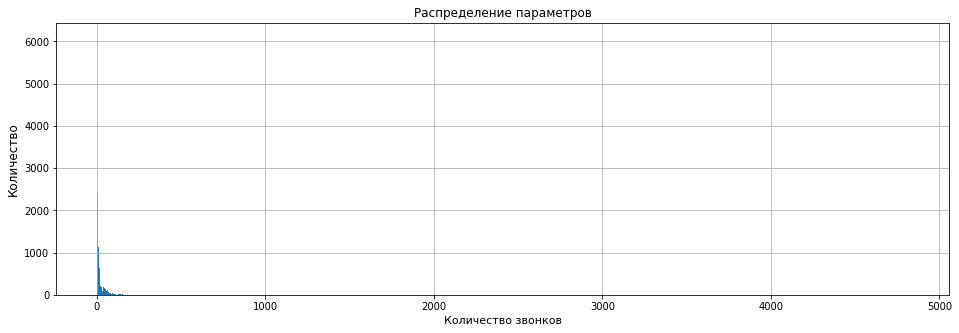

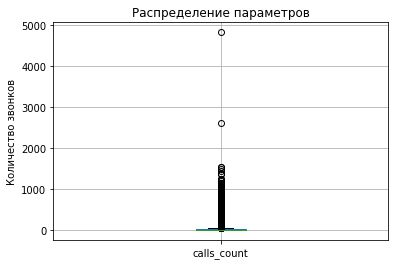


Колонка: call_duration 
Основные характеристики:
 count    23,869.000
mean      1,336.298
std       5,221.287
min           0.000
25%           0.000
50%          46.000
75%       1,038.000
max     144,395.000
Name: call_duration, dtype: float64


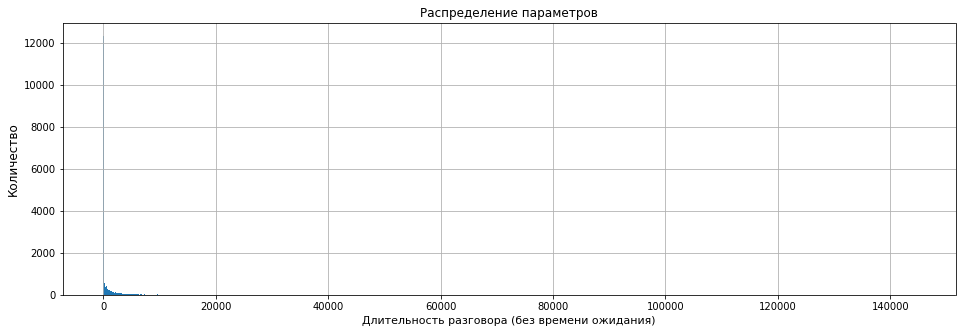

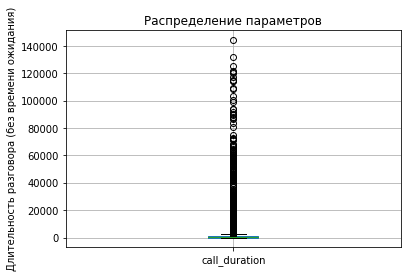


Колонка: waiting_time 
Основные характеристики:
 count   23,869.000
mean       486.759
std      1,520.991
min          0.000
25%         37.000
50%        129.000
75%        397.000
max     46,474.000
Name: waiting_time, dtype: float64


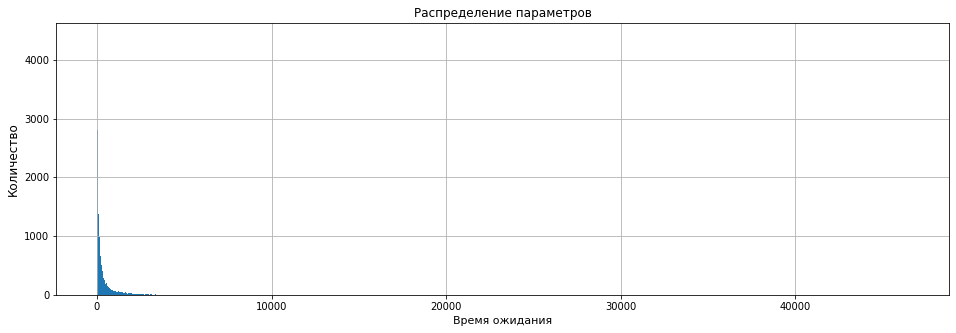

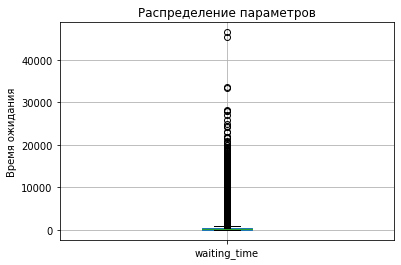


Колонка: avg_wait_time 
Основные характеристики:
 count   23,869.000
mean        18.213
std         10.800
min          0.000
25%         11.444
50%         16.600
75%         23.000
max        451.204
Name: avg_wait_time, dtype: float64


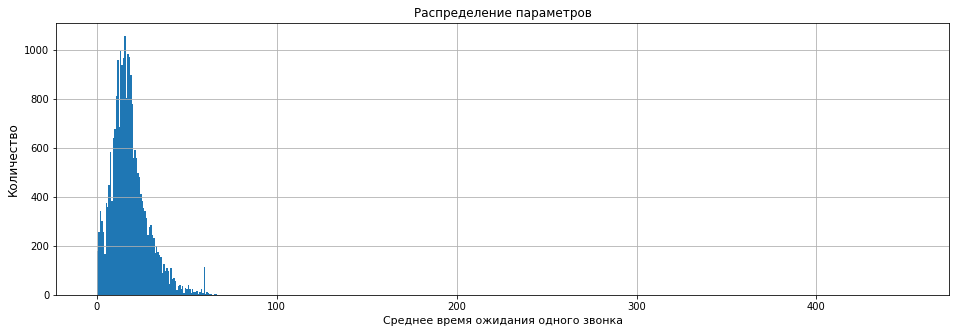

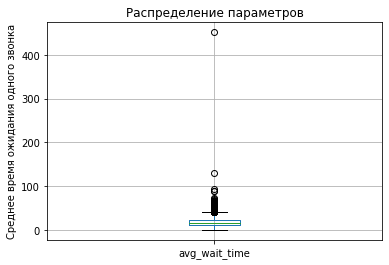

In [38]:
analis(out_not_missed_calls, parametrs)

Та же проблема с большим количеством выбросов. Избавимся от них.

In [39]:
out_not_missed_calls = out_not_missed_calls[out_not_missed_calls['calls_count'] <= out_not_missed_calls['calls_count'].quantile(0.90)]
out_not_missed_calls = out_not_missed_calls[out_not_missed_calls['call_duration'] <= out_not_missed_calls['call_duration'].quantile(0.90)]
out_not_missed_calls = out_not_missed_calls[out_not_missed_calls['waiting_time'] <= out_not_missed_calls['waiting_time'].quantile(0.90)]


Колонка: calls_count 
Основные характеристики:
 count   17,447.000
mean         6.959
std          7.168
min          1.000
25%          2.000
50%          4.000
75%         10.000
max         54.000
Name: calls_count, dtype: float64


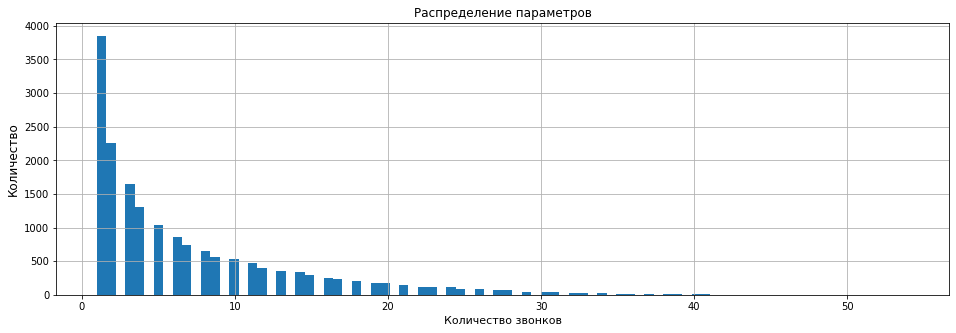

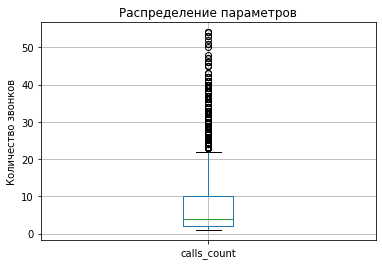


Колонка: call_duration 
Основные характеристики:
 count   17,447.000
mean       333.371
std        537.108
min          0.000
25%          0.000
50%         13.000
75%        486.000
max      2,290.000
Name: call_duration, dtype: float64


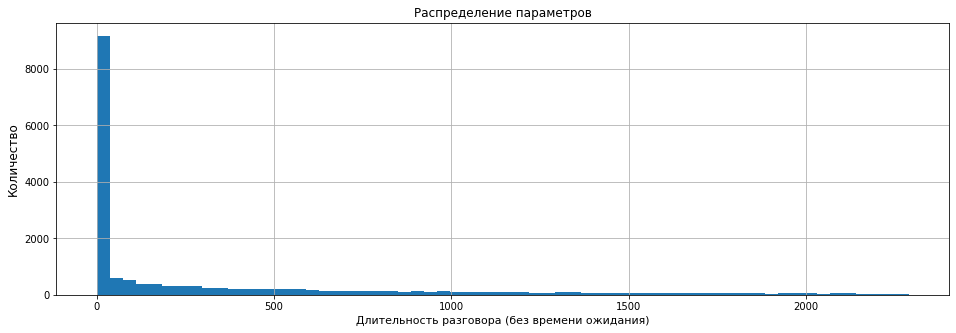

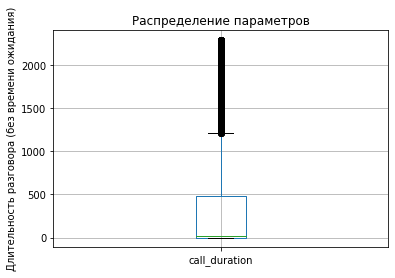


Колонка: waiting_time 
Основные характеристики:
 count   17,447.000
mean       117.624
std        121.910
min          0.000
25%         24.000
50%         69.000
75%        175.000
max        509.000
Name: waiting_time, dtype: float64


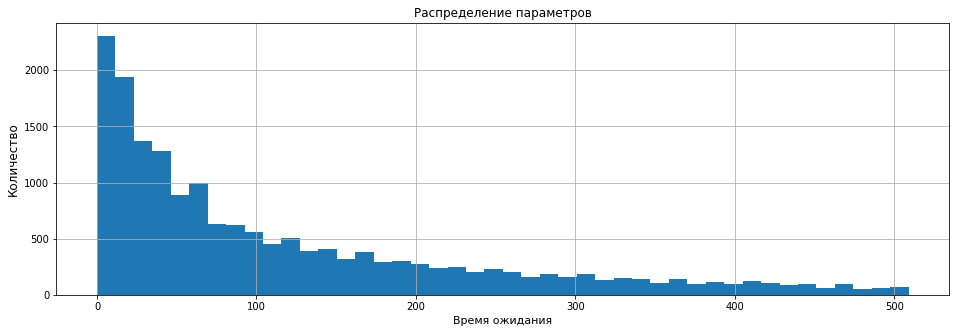

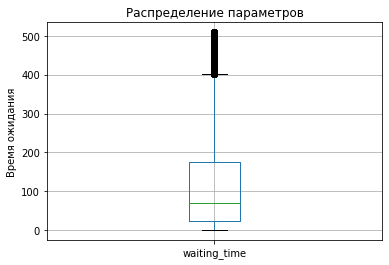


Колонка: avg_wait_time 
Основные характеристики:
 count   17,447.000
mean        17.725
std         11.425
min          0.000
25%         10.077
50%         15.250
75%         23.000
max        130.500
Name: avg_wait_time, dtype: float64


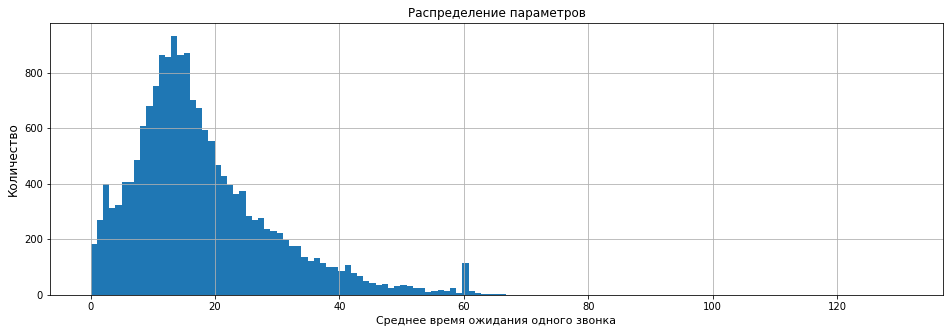

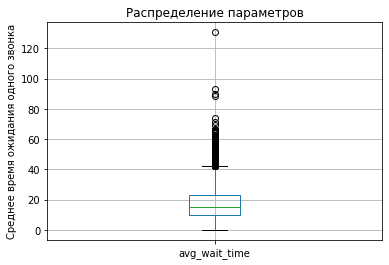

In [40]:
analis(out_not_missed_calls, parametrs)

Как видим cреднее время ожидания одного звонка составляет около 15секунд. Неожиданно у многих звонков длительность в районе нуля, хотя звонки не пропущенные. Т.е.скорее всего человек берет трубку и сразу вешает ее. Возможно клиенты провайдера колл-центры рекламирующие какие-то товары или услуги, может даже спам.
Большинство значений находится в диапозоне от 1 до 10 звонков в день.
Среднее значение по выборке - 7 исходящих звонков в день. Это очень мало. 
Но сейчас мы смотрим данные по всем операторам. Стоит проанализировать именно операторов, специализирующихся на обзвонах.

Из [внешних источников](https://calldirect.ru/skolko-zvonkov-dolzhen-delat-operator-koll-czentra/) можем найти информацию, что нормой для оператора, специализирующегося на обзвоне клиентов является 144 звонка в день. Но это явно не наш случай.

#### Исследование пропущенных входящих вызовов

In [41]:
data_clear.query('direction == "in"')['is_missed_call'].value_counts()

False    11994
True       684
Name: is_missed_call, dtype: int64

Пропущенных входящих вызов всего **684**

In [42]:
missed_calls = data_clear.query('is_missed_call == True and direction == "in"')

У нас есть данные с **2 августа 2019г** по **28 августа 2019г** за **119** календарных дней. Брать общее количество пропущенных звонков по операторам и сравнивать их не корректно, так как операторы работали разное количество дней. Посчитаем для каждого оператора пропущенные входящие звонки за каждый день и выведем среднее количество.

In [43]:
cnt_missed_calls = missed_calls.groupby(['operator_id', 'date'])['calls_count'].mean().reset_index()
cnt_missed_calls.head()

,operator_id,date,calls_count
0,882680,2019-09-05,1.000
1,882680,2019-09-10,1.000
2,882680,2019-09-13,1.000
3,882684,2019-08-19,1.000
4,882684,2019-08-24,1.000


In [44]:
cnt_missed_calls['calls_count'].describe()

count   683.000
mean      1.352
std       1.016
min       1.000
25%       1.000
50%       1.000
75%       1.000
max      13.000
Name: calls_count, dtype: float64

в основном у операторов не больше одного входящего пропущенного звонка. Хотя есть оператор пропустивший и 13 звонков.

In [45]:
cnt_missed_calls = cnt_missed_calls.query('calls_count <= calls_count.quantile(0.95)')
cnt_missed_calls['calls_count'].describe()

count   657.000
mean      1.196
std       0.480
min       1.000
25%       1.000
50%       1.000
75%       1.000
max       3.000
Name: calls_count, dtype: float64

Из открытых [источников](https://wilstream.ru/stati/kpi-koll-tsentra/) можно узнать что CAR: call abandonment rate — показатель необработанных вызовов
`CAR` — самый страшный показатель для бизнеса. Он измеряет количество звонков, во время которых клиент положил трубку, не дождавшись ответа. Практически каждый такой кейс — это упущенная сделка.

`CAR` зависит не только от качества работы колл-центра, но и от того, какой уровень сервиса ожидают клиенты от компании. Индустриальный стандарт — **5–8** %.
Примем это к сведению и постараемся посчитать сколько в наших данных у операторов `СAR`.

### Смотрим корреляцию данных

Посмотрим есть ли у нас какие-то явные зависимости между звонками, временем ожидания, и длительностью звонков.

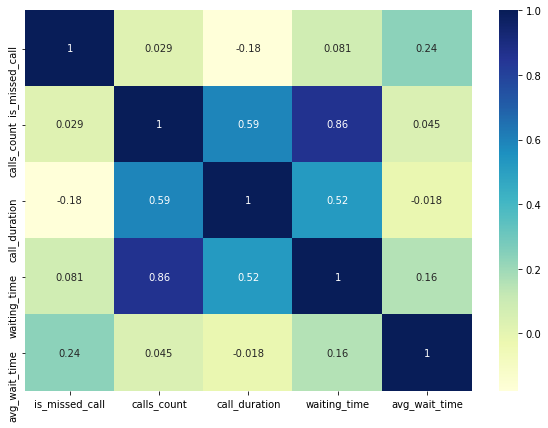

In [46]:
plt.figure(figsize=(10,7))
sns.heatmap(data_clear[['is_missed_call', 'calls_count', 'call_duration', 'waiting_time', 'avg_wait_time']].corr(), annot=True, cmap="YlGnBu");

Неожиданно высокая корреляция между временем ожидания и количеством звонков, предположу что это связано с тем что в период наплыва звонящих приходится дольше ждать на линии.

### Исследуем активность по количеству звонков в разные дни недели

#### Входящие по дням недели

,calls_count
day_of_week,
0,16589
1,18047
2,16947
3,17494
4,14271
5,6276
6,4118


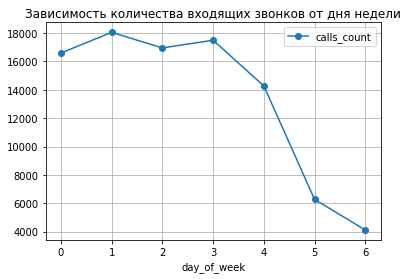

In [47]:
# создадим сводную таблицу по дням недели
incoming_calls_day = incoming_calls.pivot_table(index="day_of_week", values="calls_count", aggfunc="sum")
display(incoming_calls_day)

# построим график зависимости
incoming_calls_day.plot(style='o-', title="Зависимость количества входящих звонков от дня недели", grid=True)
plt.show;

На выходные приходится значительно меньшее количество входящих чем в буднии дни.

#### Исходящие по дням недели

,calls_count
day_of_week,
0,105205
1,113680
2,109483
3,113388
4,101692
5,37530
6,27365


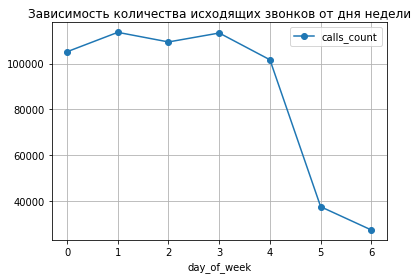

In [48]:
# создадим сводную таблицу по дням недели
out_calls_day = out_calls.pivot_table(index="day_of_week", values="calls_count", aggfunc="sum")
display(out_calls_day)

# построим график зависимости
out_calls_day.plot(style='o-', title="Зависимость количества исходящих звонков от дня недели", grid=True)
plt.show;

Картина та же, что и по входящим - на выходные приходится намного меньше звонков.

### Исследуем данные с пропущенным значением `operator_id`

Посмотрим есть ли какая-то логика в данных с пропущенным `operator_id`.

In [49]:
display(data_operator_nan.sample(5))
print('\033[1m' + 'Входящие/Исходящие:' + '\033[0m')
print(data_operator_nan['direction'].value_counts())
print('\033[1m' + 'Пропущенные/Не пропущенные:' + '\033[0m')
print(data_operator_nan['is_missed_call'].value_counts())
print('Количество пользователей у которых попадаются пропущенные операторы:', data_operator_nan['user_id'].nunique())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day_of_week,month
29293,167455,2019-10-19,in,False,NaN,True,1,0,5,5,10
40455,168054,2019-11-13,in,False,NaN,True,5,0,10,2,11
26973,167263,2019-09-18,in,False,NaN,True,2,0,36,2,9
48961,168601,2019-11-16,in,False,NaN,True,1,0,0,5,11
26833,167242,2019-11-07,in,False,NaN,True,4,0,1,3,11


Входящие/Исходящие:
in     7217
out     184
Name: direction, dtype: int64
Пропущенные/Не пропущенные:
True     7288
False     113
Name: is_missed_call, dtype: int64
Количество пользователей у которых попадаются пропущенные операторы: 305


В данных присутствуют как входящие, так и исходящие, и пропущенные и нет, хотя стоит отметить что большая часть приходится на входящие пропущенные звонки. Так же мы проверили, что эти записи не относятся к какому-то одному пользователю, таких много. Проверим предположение, что это звонки приходящиеся на выходные, когда большинство операторов не работает. 

,day_of_week,mean,sum
0,0,15.613,"18,095.000"
1,1,15.647,"19,903.000"
2,2,13.343,"16,746.000"
3,3,14.280,"17,850.000"
4,4,14.140,"16,516.000"
5,5,13.883,"9,524.000"
6,6,9.435,"5,765.000"


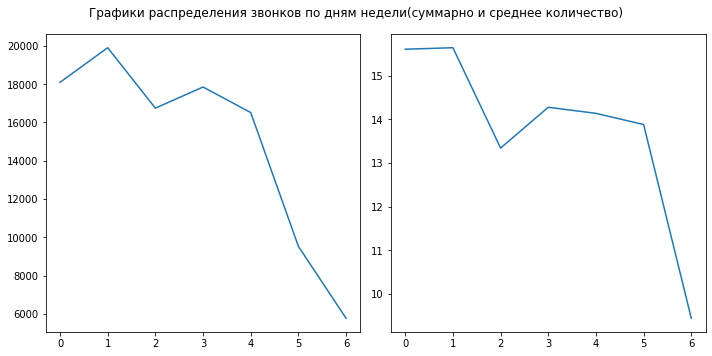

In [50]:
# создадим сводную таблицу по дням недели
data_operator_nan_day = data_operator_nan.pivot_table(index="day_of_week", values="calls_count", aggfunc=("sum", "mean")).reset_index()
display(data_operator_nan_day)
# построим графики зависимости
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(data_operator_nan_day['sum'])
plt.style='o-'
plt.title = "Oбъем звонков по дням недели"
plt.grid=True

plt.subplot(1,2,2)

plt.plot(data_operator_nan_day['mean'])
plt.style='o-'
plt.title = "Среднее количество звонков по дням недели"
plt.grid=True
plt.suptitle('Графики распределения звонков по дням недели(суммарно и среднее количество)')
plt.tight_layout()
plt.show;

Гипотеза не подтвердилась, на выходные наоборот звонков было меньше. В целом картина схожа с графиками входящих и исходящих где значение operator_id не пропущено.

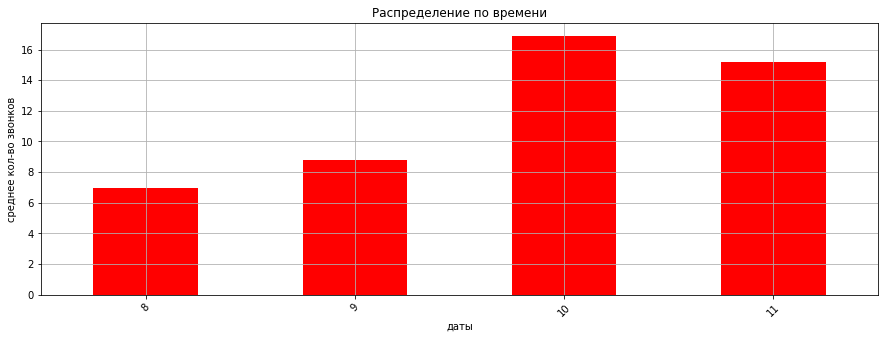

In [51]:
#посмотрим по месяцам
plt.figure(figsize=(15, 5))
data_operator_nan.groupby("month")['calls_count']\
                 .agg("mean").plot(kind="bar", title="Распределение по времени", grid=True, color = 'red')
plt.ylabel("среднее кол-во звонков")
plt.xlabel("даты")
plt.xticks(rotation = 45)
plt.show;

Наибольшее количество звонков без operator_id в октябре, но в целом они зафиксированы в каждом месяце, т.е.нельзя говорить о каком-то единоразовом сбое в работе системы.

### Исследуем разные тарифы

Теперь соединим основную таблицу с таблицей с тарифами

In [52]:
data_with_tarifs = data_clear.merge(tarifs, on='user_id', how='left')
data_with_tarifs['user_id'].nunique()

290

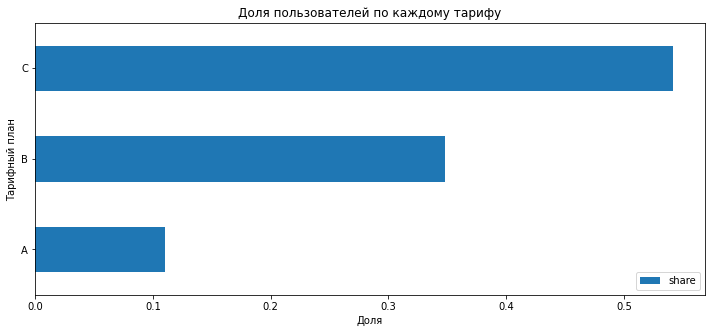

In [53]:
tarifs_group = data_with_tarifs.groupby('tariff_plan').agg({'user_id':'nunique'}).rename(columns={'user_id':'count_users'})
tarifs_group['share'] = tarifs_group['count_users']/data_with_tarifs['user_id'].nunique()
ax = tarifs_group[['share']].plot(kind='barh', figsize=(12,5))
ax.set(title='Доля пользователей по каждому тарифу', xlabel='Доля', ylabel='Тарифный план')
plt.show()

Наибольшее количество пользователей использует тариф - `С`.

In [54]:
#сгруппируем данные по тарифному плану и направлению вызовов
print('\033[1m' + 'Тарифы/Направление вызова:' + '\033[0m')
data_with_tarifs.groupby(['tariff_plan', 'direction'])['user_id'].agg('count')

Тарифы/Направление вызова:


tariff_plan  direction
A            in            3454
             out           8759
B            in            4164
             out          10303
C            in            5060
             out           9751
Name: user_id, dtype: int64

Во всех тарифах есть как входящие так и исходящие вызовы.

In [55]:
#сгруппируем данные по тарифному плану и признаком "пропущенности" вызова
print('\033[1m' + 'Тарифы/Пропущен ли вызов:' + '\033[0m')
data_with_tarifs.groupby(['tariff_plan', 'is_missed_call'])['user_id'].agg('count')

Тарифы/Пропущен ли вызов:


tariff_plan  is_missed_call
A            False             7893
             True              4320
B            False             9496
             True              4971
C            False             9993
             True              4818
Name: user_id, dtype: int64

Соотношение пропущенных и принятых/исходящих звонков кардинально не отличается от тарифа к тарифу.

### Вывод

В ходе исследовательского анализа данных были произведены условные разделения на операторов, которые специализируются на обзвонах и операторов, которые специализируются на входящих звонках. Условные, потому что мы не можем подтвердить наши данные, мы не знаем специфику колл-центров. Также есть немало операторов выполняющих входящие и исходящие вызовы параллельно. 

- Выявленна неожиданно высокая корреляция между временем ожидания и количеством звонков, предположу что это связано с тем что в период наплыва звонящих приходится дольше ждать на линии.
- На выходные приходится значительно меньшее количество входящих чем в буднии дни.
- Данные с пропущенным значением operator_id ничем не отличаются от остальных данных(на выходных так же меньше звонков, есть как пропущенные так и нет, внутренние и внешние). И такие данные присутствуют в каждом месяце и у многих операторов.
- Среди трех тарифов больше всего пользователей пользуются тарифом С
- Соотношение пропущенных и принятых/исходящих звонков кардинально не отличается от тарифа к тарифу.

Пороги для определения эффективности операторов:
- Время ожидания про входящем непропущенном звонке - **20** секунд, после которого время ожидания будет считаться высоким. 
- Количество исходящих меньше **144**
- Больше **8%** от общего количества звонков являются пропущенными.

## Оценка эффективности операторов

### Анализ данных операторов, у которых длительное время ожидания ответа при входящих внешних звонках

In [56]:
#сначала сгрупируем данные по операторам
avg_wait_time = incoming_operators.query('internal == False').groupby('operator_id')['avg_wait_time'].mean().reset_index()

In [57]:
#создадим функцию для категоризации операторов по времени ожидания
def check_avg_wait_time(avg_wait_time):
    if avg_wait_time > 20:
        return 'не эффективный'
    else:
        return 'эффективный'

In [58]:
avg_wait_time['check'] = avg_wait_time['avg_wait_time'].apply(check_avg_wait_time)
avg_wait_time

,operator_id,avg_wait_time,check
0,882476,31.667,не эффективный
1,882680,17.618,эффективный
2,884294,6.000,эффективный
3,884524,9.500,эффективный
4,886674,16.833,эффективный
...,...,...,...
263,969294,8.593,эффективный
264,971100,7.750,эффективный
265,971102,15.791,эффективный
266,971354,13.600,эффективный


In [59]:
#функция для группировки
def group_table(data, groupby, agg, rename, sort, ascending):
    if rename == 0:
        data = (data
                .groupby(groupby)
                .agg(agg)
                .reset_index()
                .sort_values(by=p_sort, ascending=ascending))
    else:
        data = (data
                .groupby(groupby)
                .agg(agg)
                .reset_index()
                .rename(columns=rename)
                .sort_values(by=sort, ascending=ascending))
    return data
#функция для отрисовки графиков
def diagrams(data, x, y, percent, title_1, ylabel, title_2):
    data.plot.bar(x=x, y=y, legend=False, title=title_1)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)
    plt.show()
    data[percent].plot(kind='pie', labels=None, label='', autopct='%1.0f%%', 
       legend=True, figsize=(10, 10), title=title_2)
    plt.show();   

,check,avg,percent
1,эффективный,168,0.627
0,не эффективный,100,0.373


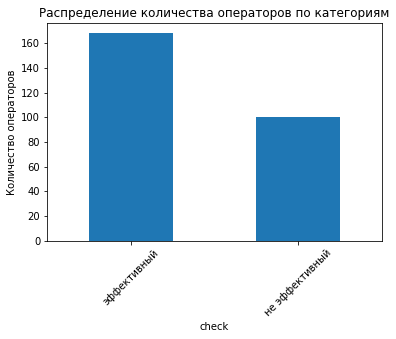

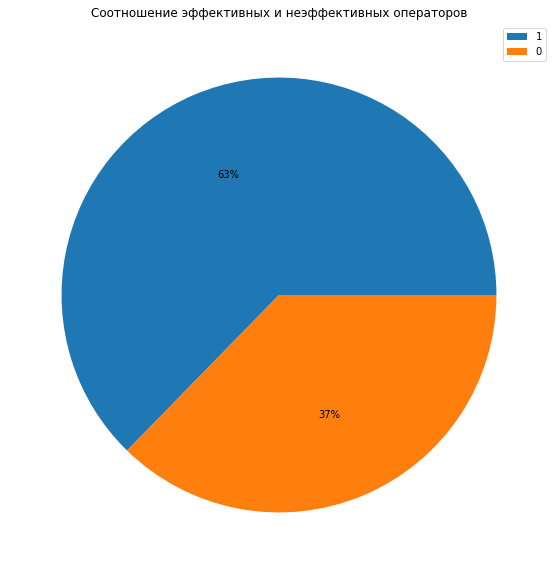

In [60]:
operators_and_wait_time = group_table(avg_wait_time, 'check', {'avg_wait_time':'count'}, {'avg_wait_time':'avg'}, 'avg', False)

operators_and_wait_time['percent'] = operators_and_wait_time['avg'] / operators_and_wait_time['avg'].sum()
display(operators_and_wait_time)

diagrams(operators_and_wait_time, 'check', 'avg', 'percent', 'Распределение количества операторов по категориям', 'Количество операторов', 'Соотношение эффективных и неэффективных операторов')

Очень много операторов являются неэффективными по этому параметру. В исследовательском анализе мы видели, что в случае с нашими операторами порог выше(в районе 35сек)-есть куда стремится!

### Анализ данных операторов, у которых большое количество пропущенных вызовов

In [61]:
# считаем метрику CAR
missed_1 = data_clear.groupby('operator_id')['calls_count'].agg('sum').reset_index()
missed_2 = data_clear.query('is_missed_call == True and direction == "in"').rename(columns={'calls_count':'missed_calls'})
missed_2 = missed_2.groupby('operator_id')['missed_calls'].agg('sum').reset_index()
missed = missed_1.merge(missed_2, on=['operator_id'], how='outer')
missed = missed[['operator_id', 'calls_count', 'missed_calls']]
missed = missed.fillna(0)

missed['CAR'] = (missed['missed_calls'] / missed['calls_count']) * 100
display(missed)

,operator_id,calls_count,missed_calls,CAR
0,879896,930,0.000,0.000
1,879898,7312,0.000,0.000
2,880020,45,0.000,0.000
3,880022,197,0.000,0.000
4,880026,2232,0.000,0.000
...,...,...,...,...
1087,972410,77,0.000,0.000
1088,972412,61,0.000,0.000
1089,972460,51,0.000,0.000
1090,973120,3,0.000,0.000


In [62]:
#функция для категоризации по CAR
def cnt_missed_call_CAR(CAR):
    if CAR > 8:
        return 'не эффективный'
    else:
        return 'эффективный'

In [63]:
missed['check'] = missed['CAR'].apply(cnt_missed_call_CAR)
missed

,operator_id,calls_count,missed_calls,CAR,check
0,879896,930,0.000,0.000,эффективный
1,879898,7312,0.000,0.000,эффективный
2,880020,45,0.000,0.000,эффективный
3,880022,197,0.000,0.000,эффективный
4,880026,2232,0.000,0.000,эффективный
...,...,...,...,...,...
1087,972410,77,0.000,0.000,эффективный
1088,972412,61,0.000,0.000,эффективный
1089,972460,51,0.000,0.000,эффективный
1090,973120,3,0.000,0.000,эффективный


,check,operator_id,cnt,missed_calls,CAR,percent
1,эффективный,1074,1074,1074,1074,0.984
0,не эффективный,18,18,18,18,0.016


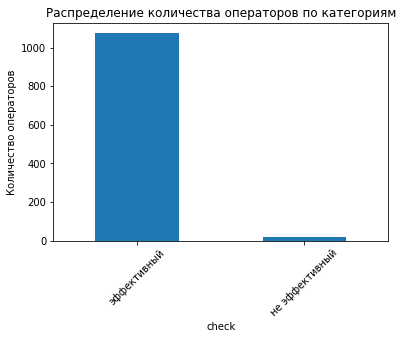

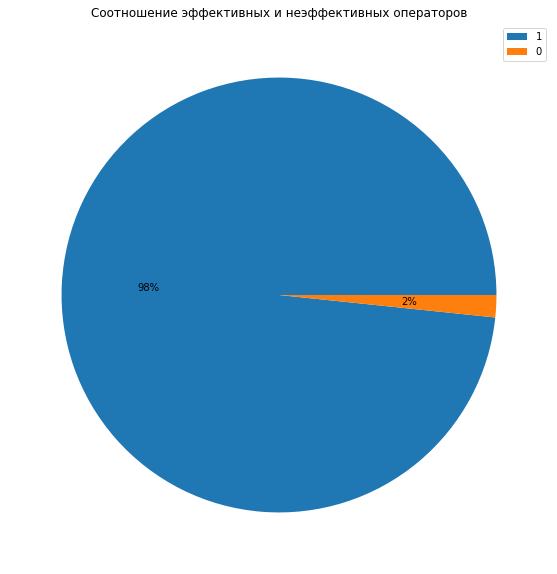

In [64]:
operators_and_missed_calls = group_table(missed, 'check', 'count', {'calls_count':'cnt'}, 'cnt', False)

operators_and_missed_calls['percent'] = operators_and_missed_calls['cnt'] / operators_and_missed_calls['cnt'].sum()
display(operators_and_missed_calls)

diagrams(operators_and_missed_calls, 'check', 'cnt', 'percent', 'Распределение количества операторов по категориям', 'Количество операторов', 'Соотношение эффективных и неэффективных операторов')

Всего 18 операторов(2%) оказались неэффективными применяя метрику CAR.

In [65]:
missed.query('check == "не эффективный"')

,operator_id,calls_count,missed_calls,CAR,check
114,894614,8,1.000,12.500,не эффективный
242,904344,9,3.000,33.333,не эффективный
246,905300,25,6.000,24.000,не эффективный
263,905862,103,15.000,14.563,не эффективный
272,906392,71,7.000,9.859,не эффективный
338,910226,8,2.000,25.000,не эффективный
349,911102,27,3.000,11.111,не эффективный
354,911142,20,2.000,10.000,не эффективный
367,913886,2,1.000,50.000,не эффективный
419,918888,11,1.000,9.091,не эффективный


C этими операторами необходимо работать, чтобы улучшать их эффективность.

### Анализ данных операторов, с малым количеством исходящих вызовов.

In [74]:
#сначала сгрупируем данные по операторам
avg_cnt_out_call = out_operators.groupby(['operator_id', 'date'])['calls_count'].sum().reset_index()

In [75]:
def cnt_out_calls(calls_count):
    if calls_count < 144:
        return 'не эффективный'
    else:
        return 'эффективный'

In [77]:
avg_cnt_out_call['check'] = avg_cnt_out_call['calls_count'].apply(cnt_out_calls)
avg_cnt_out_call.head(10)

,operator_id,date,calls_count,check
0,879896,2019-08-02,13,не эффективный
1,879896,2019-08-03,10,не эффективный
2,879896,2019-08-04,2,не эффективный
3,879896,2019-08-05,28,не эффективный
4,879896,2019-08-06,46,не эффективный
5,879896,2019-08-07,23,не эффективный
6,879896,2019-08-08,24,не эффективный
7,879896,2019-08-09,38,не эффективный
8,879896,2019-08-10,2,не эффективный
9,879896,2019-08-12,36,не эффективный


,check,operator_id,date,cnt,percent
0,не эффективный,9685,9685,9685,0.927
1,эффективный,761,761,761,0.073


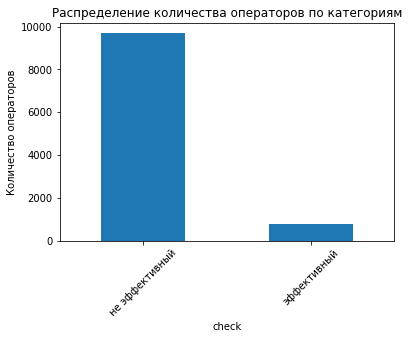

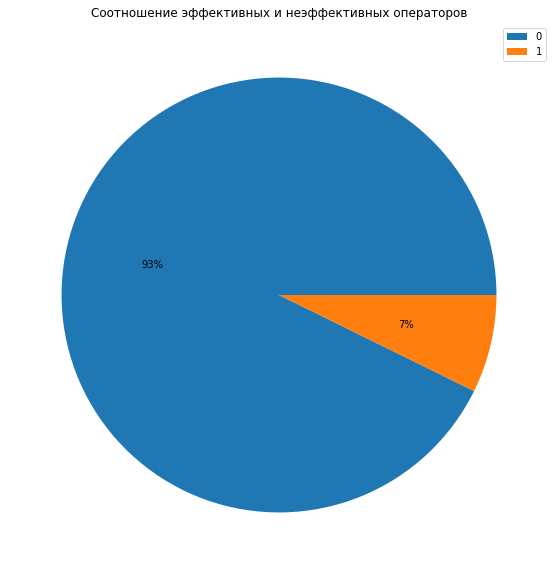

In [78]:
operators_and_out_calls = group_table(avg_cnt_out_call, 'check', 'count', {'calls_count':'cnt'}, 'cnt', False)

operators_and_out_calls['percent'] = operators_and_out_calls['cnt'] / operators_and_out_calls['cnt'].sum()
display(operators_and_out_calls)

diagrams(operators_and_out_calls, 'check', 'cnt', 'percent', 'Распределение количества операторов по категориям', 'Количество операторов', 'Соотношение эффективных и неэффективных операторов')

Практически все операторы являются неэффективными и только 7% соответствуют критериям!

### Вывод

Привлекая внешние источники задали пороги эффективности для операторов и узнали, что очень многие операторы являются неэффективными по 2м из трех критериев. Единственная метрика по которой операторы показывают неплохие результаты это соотношение пропущенных вызовов к общему количеству звонков. По этой метрике выявлено всего **18** неэффективных оператров, над всем остальным стоит работать.

## Проверка гипотез

### Гипотеза о равенстве количества входящих вызовов в пятницу и в субботу.

**Гипотеза Н0** - количество входящих вызовов в пятницу и субботу статистически не различается, **Гипотеза Н1**: количество входящих вызовов в пятницу и субботу различается.

Для проверки стат.значимости будем использовать **непараметрический тест Уилкоксона-Манна-Уитни** - тест устойчив к выбросам и анамалиям.
Непараметрических метод заключается том, что он работает с рангами, — номерами значений   в   упорядоченном ряду, —   никак не учитывая сами значения. Поэтому к ним прибегаем тогда, когда работа с самими значениями невозможна из-за      выбросов, сильно сдвигающих параметрические результаты.

Примем alpha = **0.05**

In [70]:
#сделаем выборки для анализа
friday = data_clear.query('day_of_week == 4')['calls_count']
saturday = data_clear.query('day_of_week == 5')['calls_count']

In [71]:
alpha = 0.05
results_mannwhitneyu = st.mannwhitneyu(friday, saturday)
    
print('p-значение для сравнения:', results_mannwhitneyu.pvalue)
  
if (results_mannwhitneyu.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение для сравнения: 1.630185002652818e-06
Отвергаем нулевую гипотезу: разница статистически значима


Разница в количестве звонков в пятницу и субботу статистически значима.

### Гипотеза о равенстве времени ожидания ответа в любом тарифе

**Гипотеза Н0** - время ожидания ответа не зависит от тарифного плана, **Гипотеза Н1**: время ожидания ответа зависит от тарифного плана.

Воспользуемся **H-критерием Краскела-Уоллиса** - этот тест позволяет определить значимость различий признака по нескольким группам (предназначен для проверки равенства средних нескольких выборок)

In [72]:
tariff_A = data_with_tarifs.query('tariff_plan == "A"')['waiting_time']
print('Количество строк(Тариф А):', len(tariff_A))
tariff_B = data_with_tarifs.query('tariff_plan == "B"')['waiting_time']
print('Количество строк(Тариф В):', len(tariff_B))
tariff_C = data_with_tarifs.query('tariff_plan == "C"')['waiting_time']
print('Количество строк(Тариф С):', len(tariff_C))

Количество строк(Тариф А): 12213
Количество строк(Тариф В): 14467
Количество строк(Тариф С): 14811


Примем alpha равное 0,05.

In [73]:
alpha = 0.05
results = scipy.stats.kruskal(tariff_A, tariff_B, tariff_C)
print('p-значение =', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, время ожидания ответа не зависит от тарифного плана')

p-значение = 4.349112893020619e-136
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу и принимаем гипотезу **Н1** - время ожидания ответа зависит от тарифного плана, но какой тарифный план и как именно влияет на продолжительномть ожидания мы сказать не можем.

## Выводы и рекомендации

Было проанализировано **53902**строки с данными о звонках принятых, совершенных и пропущенных операторами колл-центров в период со **02 августа 2019г** по **28 ноября 2019г**. А также датасет с тарифами пользователей на **732** строки. Тарифов всего три:А, В, С. 

Данные содержали дубликаты, которые были удалены, также были убраны данные с пропущенным значением в колонке `internal`. Данные, содержащие пропуски в столбце `operator_id` были перенесены в отдельный датафрей для анализа и выявления закономерностей.

Для определения порогов эффективности были исследованы такие признаки как: 
- много пропущенных входящих звонков, 
- долгое ожидание ответа при входящих внешних вызовах, 
- мало исходящих вызовов для колл-центров, которые специализируются на обзвонах.

В ходе исследовательского анализа данных были произведены условные разделения на операторов, которые специализируются на обзвонах и операторов, которые специализируются на входящих звонках. Условные, потому что мы не можем подтвердить наши данные, мы не знаем специфику колл-центров. Также есть немало операторов выполняющих входящие и исходящие вызовы параллельно. 

- Выявленна неожиданно высокая корреляция между временем ожидания и количеством звонков, предположу что это связано с тем что в период наплыва звонящих приходится дольше ждать на линии.
- На выходные приходится значительно меньшее количество входящих чем в буднии дни.
- Данные с пропущенным значением operator_id ничем не отличаются от остальных данных(на выходных так же меньше звонков, есть как пропущенные так и нет, внутренние и внешние). И такие данные присутствуют в каждом месяце и у многих операторов.
- Среди трех тарифов больше всего пользователей пользуются тарифом С
- Соотношение пропущенных и принятых/исходящих звонков кардинально не отличается от тарифа к тарифу.

**Пороги для определения эффективности операторов:**
- Время ожидания про входящем непропущенном звонке - **20** секунд, после которого время ожидания будет считаться высоким. 
- Количество исходящих меньше **144**.
- Больше **8%** от общего количества звонков являются пропущенными.

Очень многие операторы являются неэффективными по 2м из трех критериев. Единственная метрика по которой операторы показывают неплохие результаты это соотношение пропущенных вызовов к общему количеству звонков. По этой метрике выявлено всего **18** неэффективных оператров, над всем остальным стоит работать.

Проверено **2** гипотезы:
- Гипотеза о равенстве количества входящих вызовов в пятницу и в субботу проверена **непараметрическим тестом Уилкоксона-Манна-Уитни** и отвергнута.
-  Гипотеза о равенстве времени ожидания ответа в любом тарифе проверена **H-критерием Краскела-Уоллиса** и также отвергнута.

**Предложения и рекомендации:**
- Принять индустриальные стандарты на вооружение
- Сделать проверки операторов систематическими
- Использовать алгоритм отбора неэффективных операторов и предлагать его использование  сразу же при заключении контрактов.